# Analysis of optogenetic stimulus generator test

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bluepy import Cell, Synapse, Circuit, Simulation
import os
import json

In [2]:
sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/ab3f0887-44bf-4f37-a169-c7b7e6a967e7/analyses/simulations.pkl'
sims = pd.read_pickle(sims_file)

In [3]:
def get_activity(blue_config):
    """ Returns baseline (blank), stim and opto-stim activity for opto targets of given simulation"""

    # Load simulation, circuit, and opto/stim configs
    sim = Simulation(blue_config)
    c = sim.circuit

    opto_file = os.path.join(os.path.split(blue_config)[0], 'opto_stim.json')
    assert os.path.exists(opto_file), 'ERROR: Opto config file not found!'
    with open(opto_file, 'r') as f:
        opto_cfg = json.load(f)

    stim_file = os.path.abspath(os.path.join(os.path.split(blue_config)[0], sim.config['Stimulus_spikeReplay']['SpikeFile']))
    stim_file = os.path.splitext(stim_file)[0] + '.json'
    assert os.path.exists(stim_file), 'ERROR: Stim config file not found!'
    with open(stim_file, 'r') as f:
        stim_cfg = json.load(f)

    # Determine stimulus, blank, and opto intervals
    stim_int = [[t, t + stim_cfg['cfg']['duration_stim']] for t in stim_cfg['props']['time_windows'][:-1]]
    blank_int = [[t + stim_cfg['cfg']['duration_stim'], t + stim_cfg['cfg']['duration_stim'] + stim_cfg['cfg']['duration_blank']] for t in stim_cfg['props']['time_windows'][:-1]]
    opto_int = [[opto_cfg['props']['opto_t'][i], opto_cfg['props']['opto_t'][i] + opto_cfg['props']['opto_dur'][i]] for i in range(len(opto_cfg['props']['opto_t']))]

    # Determine rel. stimulus overlap with optogenetic stimulation
    stim_opto_overlap = np.array([np.max([(max(0, min(max(stim_int[i]), max(oint)) - max(min(stim_int[i]), min(oint)))) / np.diff(stim_int[i]) for oint in opto_int]) for i in range(len(stim_int))])
    blank_opto_overlap = np.array([np.max([(max(0, min(max(blank_int[i]), max(oint)) - max(min(blank_int[i]), min(oint)))) / np.diff(blank_int[i]) for oint in opto_int]) for i in range(len(blank_int))])

    # Select (non-)overlapping intervals
    baseline_sel = [blank_int[i] for i in np.where(blank_opto_overlap == 0.0)[0]] # Blank intervals w/o opto stim (0% overlap)
    stim_sel = [stim_int[i] for i in np.where(stim_opto_overlap == 0.0)[0]] # Stim intervals w/o opto stim (0% overlap)
    opto_sel = [stim_int[i] for i in np.where(stim_opto_overlap == 1.0)[0]] # Stim intervals with opto stim (100% overlap)
    baseline_count = len(baseline_sel)
    stim_count = len(stim_sel)
    opto_count = len(opto_sel)

    # Population activity per opto target
    if 'layer' in opto_cfg['cfg']['opto_target'].keys():
        layer_dicts = []
    else: # Add per-layer targets
        num_layers = 6
        layer_dicts = [opto_cfg['cfg']['opto_target'].copy() for i in range(num_layers)]
        for i in range(num_layers):
            layer_dicts[i].update({'layer': i + 1})
    targets = [opto_cfg['cfg']['opto_target']] + layer_dicts + opto_cfg['props']['inject_target_names']
    blank_dict = {'count': baseline_count, 'rates': {}}
    stim_dict = {'count': stim_count, 'rates': {}}
    opto_dict = {'count': opto_count, 'rates': {}}
    for opto_tgt in targets:
        if isinstance(opto_tgt, dict):
            target_spec = opto_tgt.copy()
            cell_target = target_spec.pop('target', None)
            tgt_gids = c.cells.ids(target_spec)
            if cell_target is not None:
                tgt_gids = np.intersect1d(tgt_gids, c.cells.ids(cell_target))
            if 'layer' in opto_tgt:
                opto_tgt = f'FullTargetL{opto_tgt["layer"]}'
            else:
                opto_tgt = 'FullTarget'
        else:
            tgt_gids = c.cells.ids(opto_tgt)

        # Baseline activity (w/o opto)
        if baseline_count == 0:
            blank_dict['rates'][opto_tgt] = np.nan
        else:
            baseline_spikes = pd.concat([sim.spikes.get(tgt_gids, t_start=t_sel[0], t_end=t_sel[-1]) for t_sel in baseline_sel])
            blank_dict['rates'][opto_tgt] = baseline_spikes.count() / (1e-3 * np.sum([np.diff(t_sel) for t_sel in baseline_sel]) * len(tgt_gids)) # Avg. firing rate (Hz) of a target neuron

        # Stimulus activity (w/o opto)
        if stim_count == 0:
            stim_dict['rates'][opto_tgt] = np.nan
        else:
            stim_spikes = pd.concat([sim.spikes.get(tgt_gids, t_start=t_sel[0], t_end=t_sel[-1]) for t_sel in stim_sel])
            stim_dict['rates'][opto_tgt] = stim_spikes.count() / (1e-3 * np.sum([np.diff(t_sel) for t_sel in stim_sel]) * len(tgt_gids)) # Avg. firing rate (Hz) of a target neuron

        # Stimulus + opto activity
        if opto_count == 0:
            opto_dict['rates'][opto_tgt] = np.nan
        else:
            opto_spikes = pd.concat([sim.spikes.get(tgt_gids, t_start=t_sel[0], t_end=t_sel[-1]) for t_sel in opto_sel])
            opto_dict['rates'][opto_tgt] = opto_spikes.count() / (1e-3 * np.sum([np.diff(t_sel) for t_sel in opto_int]) * len(tgt_gids)) # Avg. firing rate (Hz) of a target neuron

    return blank_dict, stim_dict, opto_dict, stim_cfg, opto_cfg


In [4]:
# Load results into dataframes
blank_rates_table = sims.to_frame()
blank_rates_table.drop(columns=blank_rates_table.keys(), inplace=True)
opto_rates_table = sims.to_frame()
opto_rates_table.drop(columns=opto_rates_table.keys(), inplace=True)
for sidx, blue_config in enumerate(sims):
    activity_blank, activity_stim, activity_opto, stim_cfg, opto_cfg = get_activity(blue_config)
    for k in activity_blank['rates'].keys():
        if k not in blank_rates_table.keys():
            blank_rates_table[k] = np.full(blank_rates_table.shape[0], np.nan) # Column init
            opto_rates_table[k] = np.full(opto_rates_table.shape[0], np.nan) # Column init
        blank_rates_table.iloc[sidx, np.where(blank_rates_table.columns == k)[0]] = activity_blank['rates'][k]
        opto_rates_table.iloc[sidx, np.where(opto_rates_table.columns == k)[0]] = activity_opto['rates'][k]
rel_rates_table = opto_rates_table / blank_rates_table

/gpfs/bbp.cscs.ch/ssd/apps/hpc/jenkins/deploy/libraries/2021-01-06/linux-rhel7-x86_64/gcc-9.3.0/py-numpy-1.19.4-upzqna/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


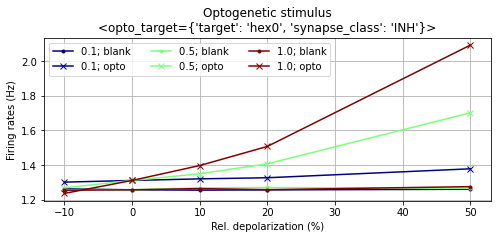

In [106]:
# Plot firing rates vs. depolarization
sub_levels = np.unique(sims.index.get_level_values('opto_sub'))
sub_colors = plt.cm.jet(np.linspace(0, 1, len(sub_levels)))
plt.figure(figsize=(8, 3))
for sub_idx, sub in enumerate(sub_levels):
        sim_sel = sims.index.get_level_values('opto_sub') == sub
        depol = opto_rates_table[sim_sel].index.get_level_values('opto_depol_pct')
        plt.plot(depol, blank_rates_table[sim_sel]['FullTarget'], '.-', color=sub_colors[sub_idx, :], label=f'{sub}; blank')
        plt.plot(depol, opto_rates_table[sim_sel]['FullTarget'], 'x-', color=sub_colors[sub_idx, :], label=f'{sub}; opto')
plt.xlabel('Rel. depolarization (%)')
plt.ylabel('Firing rates (Hz)')
plt.legend(ncol=len(sub_levels))
plt.grid()
plt.title(f'Optogenetic stimulus\n<opto_target={opto_cfg["cfg"]["opto_target"]}>')
plt.savefig('firing_rates.png', dpi=300)
plt.show()

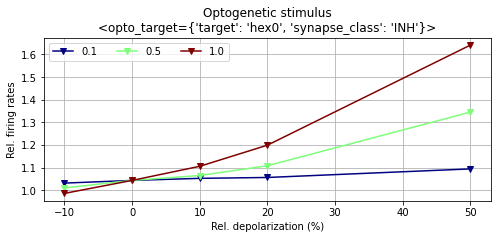

In [107]:
# Plot rel. firing rates vs. depolarization
sub_levels = np.unique(sims.index.get_level_values('opto_sub'))
sub_colors = plt.cm.jet(np.linspace(0, 1, len(sub_levels)))
plt.figure(figsize=(8, 3))
for sub_idx, sub in enumerate(sub_levels):
        sim_sel = sims.index.get_level_values('opto_sub') == sub
        depol = opto_rates_table[sim_sel].index.get_level_values('opto_depol_pct')
        plt.plot(depol, rel_rates_table[sim_sel]['FullTarget'], 'v-', color=sub_colors[sub_idx, :], label=f'{sub}')
plt.xlabel('Rel. depolarization (%)')
plt.ylabel('Rel. firing rates')
plt.legend(ncol=len(sub_levels))
plt.grid()
plt.title(f'Optogenetic stimulus\n<opto_target={opto_cfg["cfg"]["opto_target"]}>')
plt.savefig('rel_firing_rates.png', dpi=300)
plt.show()

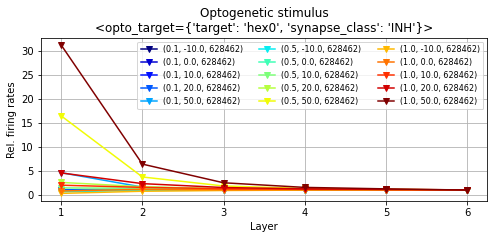

In [108]:
# Plot rel. firing rates vs. injection targets (depths)
sim_colors = plt.cm.jet(np.linspace(0, 1, sims.shape[0]))
num_layers = 6
layer_targets = [f'FullTargetL{lidx + 1}' for lidx in range(num_layers)]
plt.figure(figsize=(8, 3))
for sidx in range(sims.shape[0]):
    plt.plot(np.arange(1, num_layers + 1), rel_rates_table.iloc[sidx][layer_targets], 'v-', color=sim_colors[sidx, :], label=str(rel_rates_table.index[sidx]))
plt.xlabel('Layer')
plt.ylabel('Rel. firing rates')
plt.grid()
plt.title(f'Optogenetic stimulus\n<opto_target={opto_cfg["cfg"]["opto_target"]}>')
plt.legend(loc='upper right', ncol=3, fontsize=8)
plt.savefig('rel_layer_firing_rates.png', dpi=300)
plt.show()

In [109]:
# Population response PSTHs (per layer and Exc/INH)
def plot_PSTH(blue_config, psth_bin_size=10, psth_interval=None, psth_target=None, label=None, save_fn=None):
    sim = Simulation(blue_config)
    c = sim.circuit
    layers = np.unique(c.cells.get(properties=Cell.LAYER))
    layer_colors = plt.cm.jet(np.linspace(0, 1, len(layers)))
    syn_classes = np.unique(c.cells.get(properties=Cell.SYNAPSE_CLASS))
    syn_ls = ['-', '--'] # Linestyles

    stim_spike_file = os.path.abspath(os.path.join(os.path.split(blue_config)[0], sim.config['Stimulus_spikeReplay']['SpikeFile']))
    stim_cfg_file = os.path.splitext(stim_spike_file)[0] + '.json'
    with open(stim_cfg_file, 'r') as f:
        stim_cfg = json.load(f)

    num_patterns = max(stim_cfg['props']['stim_train']) + 1
    stim_train = stim_cfg['props']['stim_train']
    time_windows = stim_cfg['props']['time_windows']

    assert psth_bin_size > 0, 'ERROR: PSTH bin size (ms) must be larger than 0 ms!'
    if psth_interval is None:
        psth_interval = [0, np.max(np.diff(time_windows))]

    t_len = np.diff(psth_interval)[0]
    num_bins = np.round(t_len / psth_bin_size).astype(int)
    bins = np.arange(num_bins + 1) * psth_bin_size + psth_interval[0]

    fig, ax = plt.subplots(1, num_patterns, figsize=(3.5 * num_patterns, 3.5), dpi=300)
    if not hasattr(ax, '__iter__'):
        ax = [ax]
    ax[0].set_ylabel(f'Firing rates (Hz)')
    mean_PSTHs = np.zeros((len(syn_classes), num_patterns, num_bins))
    for lidx, lay in enumerate(layers):
        for sclidx, sclass in enumerate(syn_classes):
            gids_sel = np.intersect1d(sim.target_gids, c.cells.ids({Cell.LAYER: lay, Cell.SYNAPSE_CLASS: sclass}))
            if psth_target is not None:
                gids_sel = np.intersect1d(gids_sel, c.cells.ids(psth_target))
            stim_spikes = sim.spikes.get(gids=gids_sel)
            num_cells = len(gids_sel)

            pattern_spikes = [[]] * num_patterns
            for sidx, pidx in enumerate(stim_train):
                spikes = stim_spikes[np.logical_and(stim_spikes.index - time_windows[sidx] >= psth_interval[0],
                                                    stim_spikes.index - time_windows[sidx] < psth_interval[-1])]
                spikes.index = spikes.index - time_windows[sidx] # Re-align to stimulus onset
                pattern_spikes[pidx] = pattern_spikes[pidx] + [spikes]

            num_stim_per_pattern = [len(p) for p in pattern_spikes]
            pattern_spikes = [pd.concat(p) for p in pattern_spikes]

            for pidx in range(num_patterns):
                if num_cells > 0:
                    pattern_PSTH = 1e3 * np.histogram(pattern_spikes[pidx].index, bins=bins)[0] / (psth_bin_size * num_cells * num_stim_per_pattern[pidx])
                    mean_PSTHs[sclidx, pidx, :] = mean_PSTHs[sclidx, pidx, :] + pattern_PSTH / len(layers)
                    ax[pidx].plot(bins[:-1] + 0.5 * psth_bin_size, pattern_PSTH, color=layer_colors[lidx], linestyle=syn_ls[sclidx], label=f'L{lay}-{sclass}' if pidx == num_patterns - 1 else None)
                ax[pidx].set_xlim((min(bins), max(bins)))
                ax[pidx].set_xlabel('Time (ms)')
                ax[pidx].set_title(f'Pattern {pidx} (N={num_stim_per_pattern[pidx]})', fontweight='bold')
    for sclidx, sclass in enumerate(syn_classes):
        for pidx in range(num_patterns):
            ax[pidx].plot(bins[:-1] + 0.5 * psth_bin_size, mean_PSTHs[sclidx, pidx, :], color='k', linestyle=syn_ls[sclidx], linewidth=2, label=f'Mean-{sclass}' if pidx == num_patterns - 1 else None)
    max_lim = max([max(ax[pidx].get_ylim()) for pidx in range(num_patterns)])
    for pidx in range(num_patterns):
        ax[pidx].set_ylim((0, max_lim))
        ax[pidx].plot(np.zeros(2), ax[pidx].get_ylim(), '-', color='darkgrey', linewidth=2, zorder=0)
    if psth_target is None:
        tgt_name = 'Population'
    else:
        tgt_name = f'"{psth_target}"'
    if label is None:
        lbl_str = ''
    else:
        lbl_str = f' ({label})'
    fig.suptitle(f'{tgt_name} PSTHs{lbl_str}', fontweight='bold')
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.93), ncol=(len(layers) + 1) * len(syn_classes), fontsize=6)
    fig.tight_layout()

    if save_fn is not None:
        plt.savefig(save_fn, dpi=300)

/gpfs/bbp.cscs.ch/ssd/apps/hpc/jenkins/deploy/libraries/2021-01-06/linux-rhel7-x86_64/gcc-9.3.0/py-numpy-1.19.4-upzqna/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


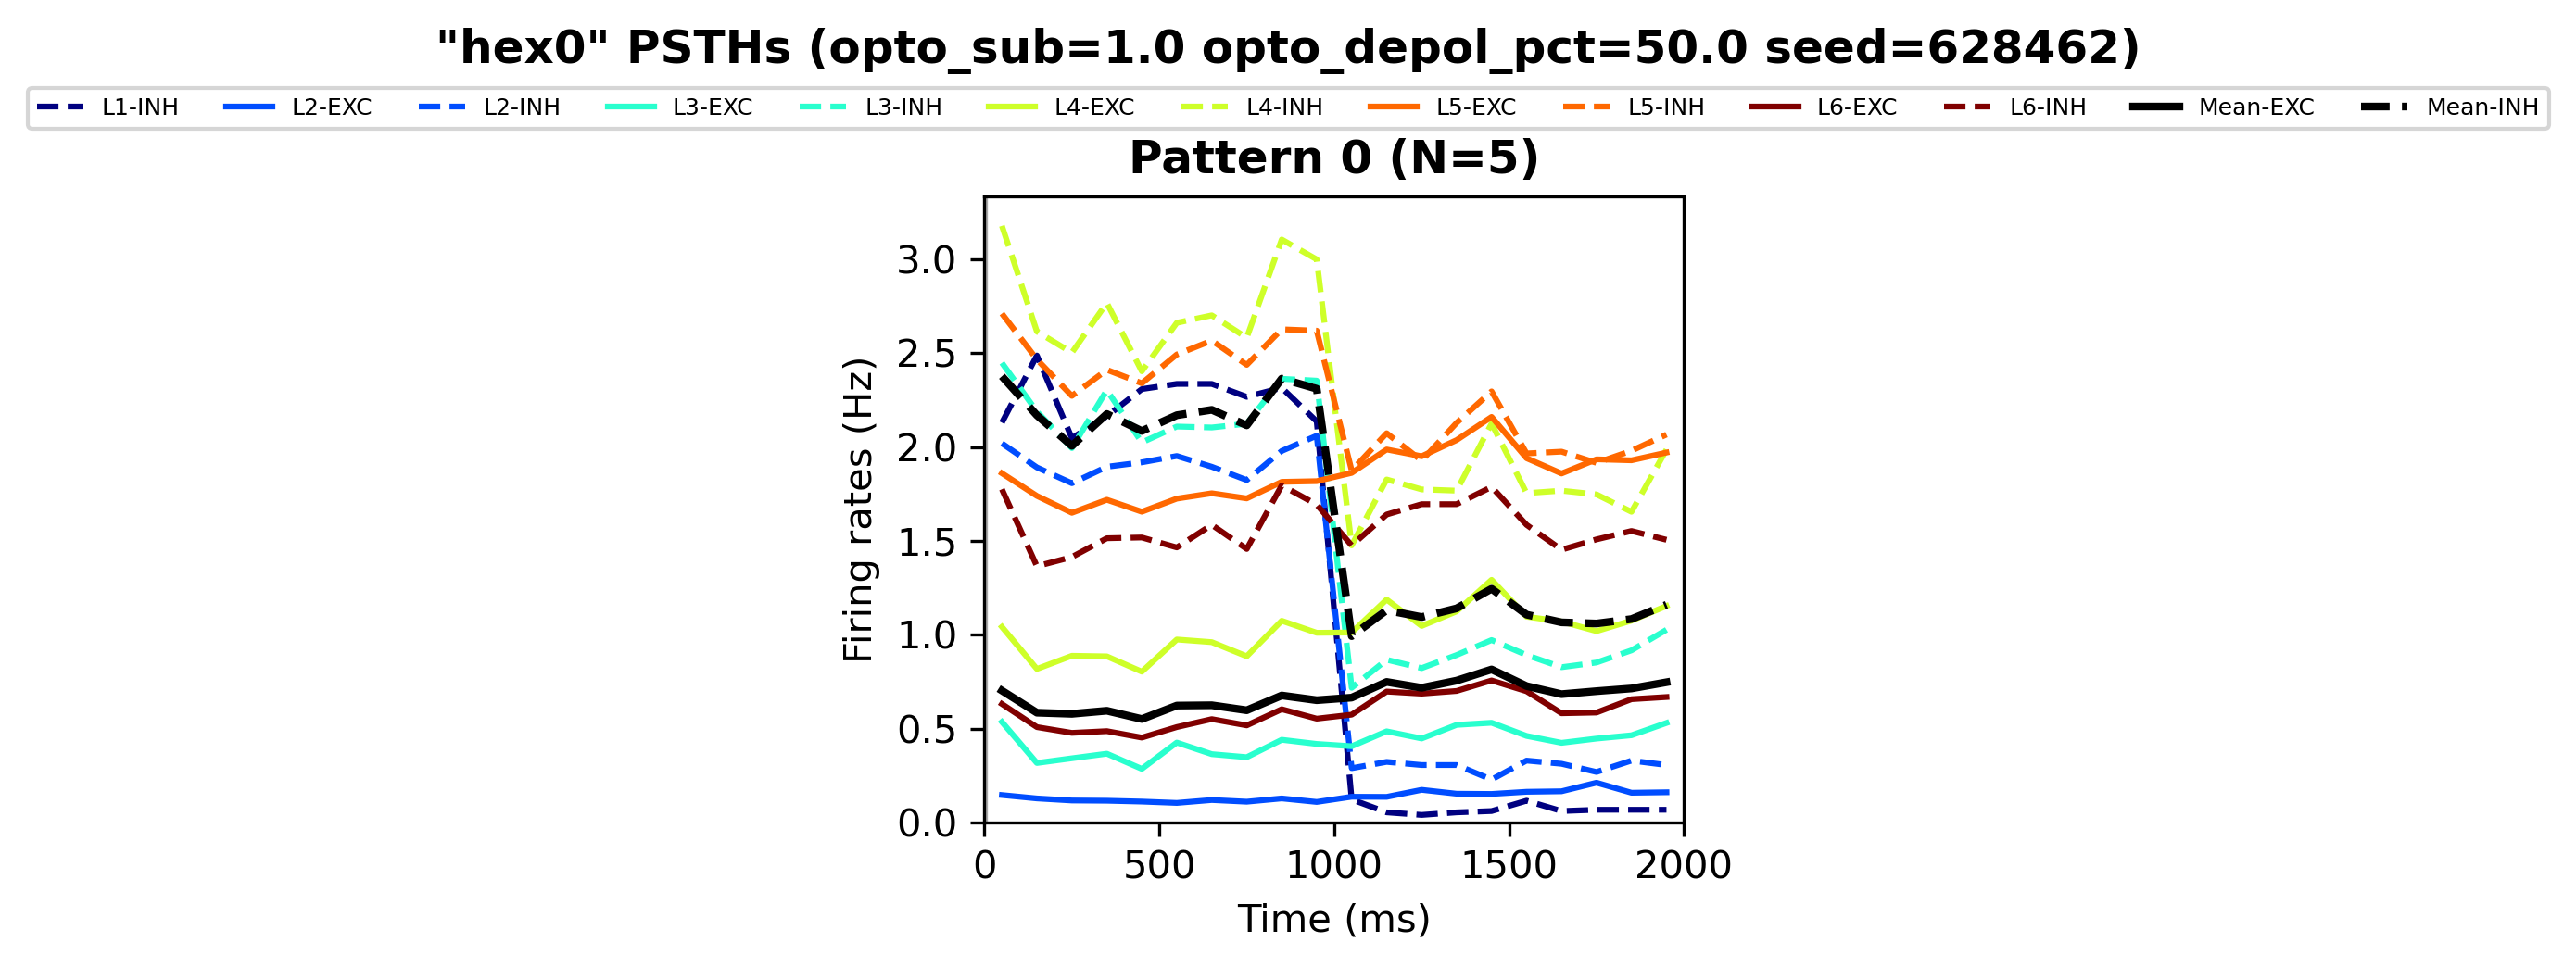

In [105]:
# for idx, blue_config in enumerate(sims):
#     plot_PSTH(blue_config, psth_bin_size=100, psth_interval=None, psth_target='hex0', label=' '.join([f'{i[0]}={i[1]}' for i in zip(sims.index.names, sims.index[idx])]))

idx = 14
blue_config = sims.iloc[idx]
plot_PSTH(blue_config, psth_bin_size=100, psth_interval=None, psth_target='hex0', label=' '.join([f'{i[0]}={i[1]}' for i in zip(sims.index.names, sims.index[idx])]), save_fn='psth.png')

In [73]:
# Voltage traces
target = 'hex0'
syn_class = 'INH'
cell_count = 100 # Number of cells to select

sims_sel = sims[sims.index.get_level_values('opto_sub') == 1.0]
depol = sims_sel.index.get_level_values('opto_depol_pct').to_numpy()

c = Circuit(sims_sel.iloc[0])
gids = c.cells.ids(target)
gids = np.intersect1d(gids, c.cells.ids({'synapse_class': syn_class}))
if len(gids) > cell_count:
    gids = np.random.choice(gids, cell_count, replace=False)

v_traces = []
for blue_config in sims_sel:
    sim = Simulation(blue_config)
    soma_report = sim.report('soma')
    v_traces.append(soma_report.get(gids=gids, t_step=1.0))

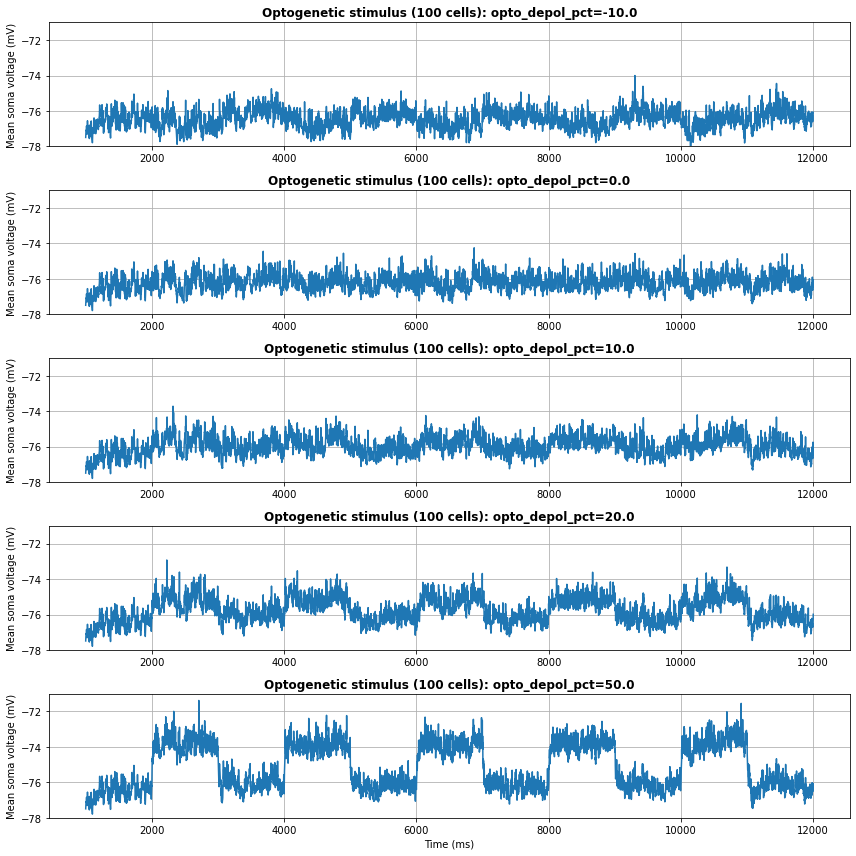

In [102]:
v_lim = [-78, -71]
plt.figure(figsize=(12, 12))
for idx, v_tr in enumerate(v_traces):
    plt.subplot(len(v_traces), 1, idx + 1)
    t = v_tr.index
    v = v_tr.to_numpy().T
#     plt.plot(t, v.T, color='grey', linewidth=0.2)
    plt.plot(t, np.mean(v, 0))
    plt.ylim(v_lim)
    plt.grid()
    plt.ylabel(f'Mean soma voltage ({soma_report.meta["data_unit"]})')
    plt.title(f'Optogenetic stimulus ({len(gids)} cells): opto_depol_pct={depol[idx]}', fontweight='bold')
plt.xlabel(f'Time ({soma_report.meta["time_unit"]})')
plt.tight_layout()
plt.savefig('opto_voltage.png', dpi=300)
plt.show()